# 🧠 First-Visit Monte Carlo Prediction

## 📘 1. Introdução

O **método de predição Monte Carlo de primeira visita** (*First-Visit Monte Carlo Prediction*) é um algoritmo de **aprendizado por reforço** usado para **estimar a função de valor de estados $V(s)$** de uma política fixa $\pi$, **sem precisar conhecer o modelo do ambiente**.

Ele aprende a partir de episódios completos, ou seja, interações reais entre agente e ambiente, e estima os valores médios das recompensas recebidas.

## 🧩 2. Objetivo

O objetivo é estimar o **valor esperado de cada estado** $ s $ ao seguir uma política $ \pi $:

$$
V_\pi(s) = \mathbb{E}_\pi [G_t \mid S_t = s]
$$

onde:

- $ V_\pi(s) $: valor esperado do estado $ s $ sob a política $ \pi $;
- $G_t $: retorno total acumulado a partir do tempo $ t $:

$$
G_t = R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \dots = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}
$$

- $\gamma \in [0,1]$: fator de desconto, que pondera a importância das recompensas futuras;
- $R_t$: recompensa recebida na transição entre os estados;
- $\pi(a|s)$: política que define a probabilidade de escolher a ação $ a $ no estado $ s $.

## 🧮 3. Ideia principal do algoritmo

O método Monte Carlo calcula $V(s)$**a partir de amostras empíricas de retornos $G_t$** observadas em episódios completos.

Para cada episódio:

1. Gera uma sequência de interações até o estado terminal:
   
   $$
   S_0, A_0, R_1, S_1, A_1, R_2, ..., S_T
   $$


2. Calcula o retorno $ G_t $ de cada tempo $ t $:
   
   $$
   G_t = R_{t+1} + \gamma R_{t+2} + \dots
   $$   


3. Para cada **primeira visita** a um estado $ s $, atualiza a estimativa de $ V(s) $ como a **média dos retornos** observados:
   
   $$
   V(s) = \frac{1}{N(s)} \sum_{i=1}^{N(s)} G_i
   $$
   
   onde $N(s)$ é o número de primeiras visitas ao estado $ s$.

## 🔢 4. Fórmulas resumidas

| Símbolo | Significado |
|----------|-------------|
| $S_t$ | Estado no tempo $ t $ |
| $A_t$ | Ação no tempo $ t $ |
| $R_{t+1}$ | Recompensa após executar $ A_t $ |
| $\pi(a|s)$ | Política fixa |
| $\gamma$ | Fator de desconto |
| $G_t$ | Retorno acumulado desde $ t $ |
| $V(s)$ | Valor estimado do estado |
| $N(s)$ | Número de primeiras visitas a $ s $ |

## ⚙️ 5. Pseudocódigo do algoritmo

```text
A. Inicializar V(s) arbitrariamente   
B. Inicializar Returns(s) como lista vazia   

C. Para cada episódio:   
    C.1. Gerar um episódio seguindo a política π: S0, A0, R1, S1, ...   
    C.2. G ← 0   
    C.3. Para t = T-1 até 0:   
        C.3.1. G ← γ * G + R_{t+1}   
        C.3.2. Se St não ocorreu anteriormente no episódio:   
            C.3.2.1 Adicionar G a Returns(St)   
            C.3.2.2. V(St) ← média(Returns(St))
```

In [1]:
#! pip install gymnasium

In [2]:
# Importações
from __future__ import annotations
import numpy as np
from collections import defaultdict
from typing import Callable, Dict, Tuple, List
import matplotlib.pyplot as plt
import gymnasium as gym
import pandas as pd

In [3]:
# Tipagens
State = Tuple[int, int, bool]  # (player_sum, dealer_card, usable_ace)
Action = int                   # 0 = stick, 1 = hit
Policy = Callable[[State], Action]
ValueFunction = Dict[State, float]

## 🧩 6.1 Função generate_episode

Gera um episódio completo de interações com o ambiente seguindo uma política.

### Explicação:

- Usa o padrão da API moderna do Gymnasium `(reset() → (obs, info) e step() → (obs, reward, terminated, truncated, info))`.

- Armazena a sequência de tuplas (estado, recompensa, done, ação).

- Retorna o episódio completo e o índice do estado terminal T.

In [4]:
def generate_episode(env, policy: Policy):
    """
    Gera um episódio completo. Compatível com Gym e Gymnasium.
    
    Returns:
        trajectory: lista de (state, reward, done, action)
        T: índice do estado terminal
    """
    trajectory = []
    done = True
    At = None

    while True:
        if done:
            reset_ret = env.reset()
            if isinstance(reset_ret, tuple) and len(reset_ret) >= 1:
                St = reset_ret[0]
            else:
                St = reset_ret
            Rt = None
            done = False
        else:
            step_ret = env.step(At)
            # gymnasium: (obs, reward, terminated, truncated, info)
            if isinstance(step_ret, tuple) and len(step_ret) == 5:
                St, Rt, terminated, truncated, _ = step_ret
                done = bool(terminated or truncated)
            elif isinstance(step_ret, tuple) and len(step_ret) == 4:
                St, Rt, done, _ = step_ret
            elif isinstance(step_ret, tuple) and len(step_ret) == 3:
                St, Rt, done = step_ret
            else:
                St, Rt, done = step_ret[0], step_ret[1], step_ret[2]

        At = policy(St)
        trajectory.append((St, Rt, done, At))
        
        if done:
            break

    return trajectory, len(trajectory) - 1

### ⚙️ 6.2 Função first_visit_MC_prediction

Executa o algoritmo principal de Monte Carlo.

Explicação passo a passo

| Linha                           | Função                                                  | Descrição |
| ------------------------------- | ------------------------------------------------------- | --------- |
| `Returns`                       | Armazena listas de retornos observados para cada estado |           |
| `generate_episode`              | Gera um episódio completo                               |           |
| `for t in range(T-1, -1, -1)`   | Percorre o episódio de trás para frente                 |           |
| `G = gamma * G + Rt_1`          | Calcula o retorno acumulado com desconto                |           |
| `if St not in [traj[i][0] ...]` | Verifica se é a **primeira visita**                     |           |
| `V[St] = np.mean(Returns[St])`  | Atualiza o valor médio estimado                         |           |


In [5]:
def first_visit_MC_prediction(env, policy: Policy, episodes: int = 10000, 
                              gamma: float = 1.0, verbose: bool = False):
    """
    First-Visit Monte Carlo Prediction.
    
    Args:
        env: ambiente Gymnasium/Gym
        policy: função de política (state -> action)
        episodes: número de episódios
        gamma: fator de desconto
        verbose: se True, mostra progresso
    
    Returns:
        V: função de valor estimada {state: value}
    """
    Returns = defaultdict(list)
    V: ValueFunction = {}

    for ep in range(episodes):
        traj, T = generate_episode(env, policy)
        G = 0.0
        
        for t in range(T - 1, -1, -1):
            St, _, _, _ = traj[t]
            _, Rt_1, _, _ = traj[t + 1] if t + 1 < len(traj) else (None, 0, None, None)
            G = gamma * G + Rt_1
            
            # First-visit check
            if St not in [traj[i][0] for i in range(0, t)]:
                Returns[St].append(G)
                V[St] = np.mean(Returns[St])
        
        if verbose and (ep + 1) % max(1, episodes // 10) == 0:
            print(f"Episódios: {ep+1}/{episodes}")
    
    return V

## 🃏 6.3 Política de Blackjack

Política determinística simples usada para avaliação.

Explicação:

- O jogador para (ação 0) se a soma ≥ 20;

- Caso contrário, pede carta (ação 1).

In [6]:
# ============================================================================
# POLÍTICAS DE EXEMPLO
# ============================================================================

def policy_blackjack(state: State) -> Action:
    """
    Política simples: STICK se soma >= 20, senão HIT.
    """
    player_sum, dealer_card, usable_ace = state
    return 0 if player_sum >= 20 else 1


def policy_blackjack_advanced(state: State) -> Action:
    """
    Política heurística mais sofisticada para Blackjack.
    
    Estratégia:
    - Com ás utilizável: mais agressivo (ás flexível reduz risco)
    - Sem ás utilizável: mais conservador
    - Considera carta visível do dealer
    """
    player_sum, dealer_card, usable_ace = state

    if usable_ace:
        # Com ás utilizável (flexibilidade maior)
        if player_sum >= 19:
            return 0  # STICK com 19+
        elif 17 <= player_sum <= 18:
            return 0 if dealer_card <= 8 else 1  # depende do dealer
        else:
            return 1  # HIT abaixo de 17
    else:
        # Sem ás utilizável (risco maior de bust)
        if player_sum >= 17:
            return 0  # STICK com 17+
        elif 13 <= player_sum <= 16:
            return 1 if dealer_card >= 7 else 0  # dealer forte: HIT
        elif player_sum == 12:
            return 0 if 4 <= dealer_card <= 6 else 1  # dealer fraco: STICK
        else:
            return 1  # HIT sempre com 11 ou menos

# 📊 7. Visualização dos resultados   
## 🗺️ 7.1 Mapa de calor dos valores

Mostra o valor esperado $V(s)$ para diferentes estados.
Interpretação:

Cada célula mostra o valor esperado 

- O gráfico da esquerda representa estados com Ás “usável”.

- O da direita, estados sem Ás “usável”

In [7]:
def value_to_array(V: ValueFunction, usable_ace: bool) -> np.ndarray:
    Vd = defaultdict(float, V)
    arr = np.zeros((10, 10))
    for player_sum in range(12, 22):
        for dealer_card in range(1, 11):
            arr[player_sum - 12, dealer_card - 1] = Vd[(player_sum, dealer_card, usable_ace)]
    return arr

In [8]:
# Plotting utilities (to be executed interactively in the notebook)
# import matplotlib.pyplot as plt

def plot_value_heatmap(V, title_prefix: str = "", state_values: bool = False, 
                       fmt: str = '.2f'):
    """
    Plota heatmaps de V(s).
    PADRONIZADO com MC ES e On-Policy MC Control.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    for ax, usable_ace in zip(axes, [True, False]):
        data = value_to_array(V, usable_ace)
        im = ax.imshow(data, cmap='viridis', origin='lower', 
                      extent=[0.5, 10.5, 11.5, 21.5], aspect='auto')
        ax.set_title(f"{title_prefix}V(s) - usable_ace={usable_ace}", fontsize=12)
        ax.set_xlabel('Carta visível do dealer', fontsize=10)
        ax.set_ylabel('Soma do jogador', fontsize=10)
        ax.set_xticks(range(1, 11))
        ax.set_yticks(range(12, 22))
        
        if state_values:
            nrows, ncols = data.shape
            for i in range(nrows):
                for j in range(ncols):
                    color = 'white' if data[i, j] < 0 else 'black'
                    ax.text(j + 1, i + 12, format(data[i, j], fmt), 
                           ha='center', va='center', fontsize=7, color=color)
        
        fig.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

## 📈 7.2 Gráfico de convergência

Mostra como a média dos valores $V(s)$ converge à medida que o número de episódios aumenta.

Interpretação:

- O eixo X mostra o número de episódios simulados.
- O eixo Y mostra o valor médio absoluto dos estados.

A estabilização da curva indica convergência.

In [9]:
def plot_convergence(env, policy, episodes: int = 30000, gamma: float = 1.0,
                    window: int = 100):
    """
    Plota convergência com média móvel.
    MELHORADO com 2 subplots e análise visual.
    """
    V = {}
    Returns = defaultdict(list)
    avg_values = []

    print(f"Calculando convergência para {episodes} episódios...")
    for ep in range(episodes):
        traj, T = generate_episode(env, policy)
        G = 0.0
        
        for t in range(T - 1, -1, -1):
            St, _, _, _ = traj[t]
            _, Rt_1, _, _ = traj[t + 1] if t + 1 < len(traj) else (None, 0, None, None)
            G = gamma * G + Rt_1
            
            if St not in [traj[i][0] for i in range(0, t)]:
                Returns[St].append(G)
                V[St] = np.mean(Returns[St])
        
        avg_values.append(np.mean(list(map(abs, V.values()))) if V else 0)
        
        if (ep + 1) % max(1, episodes // 10) == 0:
            print(f"  {ep+1}/{episodes} episódios completos")

    # Plotar
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
    
    # Subplot 1: Série completa
    ax1.plot(avg_values, alpha=0.3, linewidth=0.5, label='Valores brutos')
    
    if len(avg_values) > window:
        moving_avg = np.convolve(avg_values, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(avg_values)), moving_avg, 
                linewidth=2, color='red', label=f'Média móvel ({window} ep)')
    
    ax1.set_ylabel('Valor médio absoluto |V(s)|', fontsize=10)
    ax1.set_title('Convergência do First-Visit MC Prediction', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Subplot 2: Últimos 20%
    start_idx = max(0, int(len(avg_values) * 0.8))
    ax2.plot(range(start_idx, len(avg_values)), avg_values[start_idx:], 
            linewidth=1, alpha=0.7)
    ax2.set_xlabel('Episódios', fontsize=10)
    ax2.set_ylabel('Valor médio absoluto', fontsize=10)
    ax2.set_title('Zoom - Últimos 20% dos Episódios', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    return V



```text
[Início]
   ↓
Gerar episódio → (S0, A0, R1, S1, ...)
   ↓
Calcular retornos G_t para cada t
   ↓
Para cada primeira visita a S_t:
     Atualizar média de V(S_t)
   ↓
Repetir por N episódios
   ↓
[Obter estimativas estáveis V(s)]

```

In [10]:
def value_dict_to_dataframe(V_dict, has_ace: bool) -> pd.DataFrame:
    """Converte V(s) dict em DataFrame pandas."""
    index = list(range(12, 22))
    cols = list(range(1, 11))
    data = []
    
    for ps in index:
        row = []
        for dc in cols:
            row.append(V_dict.get((ps, dc, has_ace), np.nan))
        data.append(row)
        
    df = pd.DataFrame(data, index=index, columns=cols)
    df.index.name = 'player_sum'
    df.columns.name = 'dealer_card'
    return df

In [11]:
# ============================================================================
# AVALIAÇÃO DE PERFORMANCE
# ============================================================================

def avaliar_politica_prediction(env, policy: Policy, n_jogos: int = 10000, 
                                verbose: bool = True):
    """
    Avalia performance de uma política de prediction no Blackjack.
    Adaptado para políticas que não usam Q-values.
    
    Args:
        env: ambiente Gym/Gymnasium
        policy: função de política
        n_jogos: número de jogos para avaliar
        verbose: se True, mostra detalhes
    
    Returns:
        dict com estatísticas
    """
    vitorias = 0
    derrotas = 0
    empates = 0
    recompensas = []
    
    for jogo in range(n_jogos):
        # Reset
        reset_ret = env.reset()
        state = reset_ret[0] if isinstance(reset_ret, tuple) else reset_ret
        done = False
        recompensa_episodio = 0
        
        # Jogar episódio
        while not done:
            action = policy(state)
            
            step_ret = env.step(action)
            if len(step_ret) == 5:  # Gymnasium
                state, reward, terminated, truncated, _ = step_ret
                done = terminated or truncated
            else:  # Gym
                state, reward, done, _ = step_ret
            
            recompensa_episodio = reward
        
        # Contabilizar
        recompensas.append(recompensa_episodio)
        if recompensa_episodio > 0:
            vitorias += 1
        elif recompensa_episodio < 0:
            derrotas += 1
        else:
            empates += 1
        
        # Progresso
        if verbose and (jogo + 1) % (n_jogos // 10) == 0:
            taxa_parcial = (vitorias / (jogo + 1)) * 100
            print(f"  Progresso: {jogo+1:>6}/{n_jogos} jogos | "
                  f"Win rate atual: {taxa_parcial:>5.2f}%")
    
    # Estatísticas
    taxa_vitoria = (vitorias / n_jogos) * 100
    taxa_derrota = (derrotas / n_jogos) * 100
    taxa_empate = (empates / n_jogos) * 100
    recompensa_media = np.mean(recompensas)
    
    stats = {
        'wins': vitorias,
        'losses': derrotas,
        'draws': empates,
        'total_games': n_jogos,
        'win_rate': taxa_vitoria,
        'loss_rate': taxa_derrota,
        'draw_rate': taxa_empate,
        'avg_reward': recompensa_media
    }
    
    if verbose:
        print("\n" + "="*60)
        print(" RESULTADOS DA AVALIAÇÃO")
        print("="*60)
        print(f"Total de jogos:  {n_jogos:>10,}")
        print("-"*60)
        print(f"Vitórias:        {vitorias:>10,}  ({taxa_vitoria:>6.2f}%)")
        print(f"Derrotas:        {derrotas:>10,}  ({taxa_derrota:>6.2f}%)")
        print(f"Empates:         {empates:>10,}  ({taxa_empate:>6.2f}%)")
        print("-"*60)
        print(f"Recompensa média: {recompensa_media:>9.4f}")
        print("="*60)
        
        # Interpretação
        print("\n📊 INTERPRETAÇÃO:")
        if taxa_vitoria >= 45:
            print("   🏆 EXCELENTE! Política muito forte.")
        elif taxa_vitoria >= 43:
            print("   ✅ ÓTIMO! Política próxima da ótima.")
        elif taxa_vitoria >= 40:
            print("   ✓ BOM! Política competitiva.")
        elif taxa_vitoria >= 35:
            print("   ⚠ RAZOÁVEL. Pode melhorar.")
        else:
            print("   ❌ FRACO. Política subótima.")
        
        print("\n📈 REFERÊNCIAS:")
        print("   - Estratégia aleatória:     ~28-30%")
        print("   - Estratégia dealer (≥17):  ~42-44%")
        print("   - Política ótima teórica:   ~43-46%")
        print("="*60)
    
    return stats

In [12]:
def comparar_politicas_prediction(env, policies_dict: Dict[str, Policy], 
                                  n_jogos: int = 10000):
    """
    Compara múltiplas políticas de prediction.
    
    Args:
        env: ambiente
        policies_dict: {"nome": função_política}
        n_jogos: número de jogos por política
    
    Returns:
        dict com resultados
    """
    print("\n" + "="*70)
    print(" COMPARAÇÃO DE POLÍTICAS")
    print("="*70)
    
    resultados = {}
    
    for nome, policy in policies_dict.items():
        print(f"\n[Testando] {nome}...")
        stats = avaliar_politica_prediction(env, policy, n_jogos, verbose=False)
        resultados[nome] = stats
        
        print(f"  ✓ Win Rate: {stats['win_rate']:.2f}%")
        print(f"  ✓ Avg Reward: {stats['avg_reward']:.4f}")
    
    # Plotar comparação
    _plot_comparison(resultados)
    
    return resultados


def _plot_comparison(results: Dict):
    """Plota comparação visual entre políticas."""
    names = list(results.keys())
    win_rates = [results[name]['win_rate'] for name in names]
    loss_rates = [results[name]['loss_rate'] for name in names]
    draw_rates = [results[name]['draw_rate'] for name in names]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Subplot 1: Barras empilhadas
    x = np.arange(len(names))
    width = 0.6
    
    ax1.bar(x, win_rates, width, label='Vitórias', color='green', alpha=0.8)
    ax1.bar(x, draw_rates, width, bottom=win_rates, label='Empates', 
            color='gray', alpha=0.8)
    ax1.bar(x, loss_rates, width, 
            bottom=np.array(win_rates) + np.array(draw_rates),
            label='Derrotas', color='red', alpha=0.8)
    
    ax1.set_ylabel('Porcentagem (%)', fontsize=10)
    ax1.set_title('Distribuição de Resultados', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(True, axis='y', alpha=0.3)
    
    # Subplot 2: Win rates
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(names)))
    bars = ax2.bar(x, win_rates, width, color=colors, alpha=0.8)
    
    ax2.set_ylabel('Win Rate (%)', fontsize=10)
    ax2.set_title('Taxa de Vitórias', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(names, rotation=45, ha='right')
    ax2.grid(True, axis='y', alpha=0.3)
    ax2.set_ylim([0, 100])
    
    for bar, wr in zip(bars, win_rates):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{wr:.2f}%', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## Exemplo de Uso

In [13]:
# 1. Criar ambiente
try:
    import gymnasium as gym
    env = gym.make('Blackjack-v1')
    print("✓ Usando Gymnasium")
except Exception:
    import gym
    env = gym.make('Blackjack-v0')
    print("✓ Usando Gym")

# 2. Rodar predição com política simples
print("\n" + "="*70)
print(" TESTE 1: Política Simples (STICK ≥ 20)")
print("="*70)

V_simple = first_visit_MC_prediction(
    env, policy_blackjack, episodes=20000, gamma=1.0, verbose=True
)

print(f"✓ Estados estimados: {len(V_simple)}")
print(f"✓ Valor médio: {np.mean(list(V_simple.values())):.4f}")

✓ Usando Gymnasium

 TESTE 1: Política Simples (STICK ≥ 20)
Episódios: 2000/20000
Episódios: 4000/20000
Episódios: 6000/20000
Episódios: 8000/20000
Episódios: 10000/20000
Episódios: 12000/20000
Episódios: 14000/20000
Episódios: 16000/20000
Episódios: 18000/20000
Episódios: 20000/20000
✓ Estados estimados: 280
✓ Valor médio: -0.3018


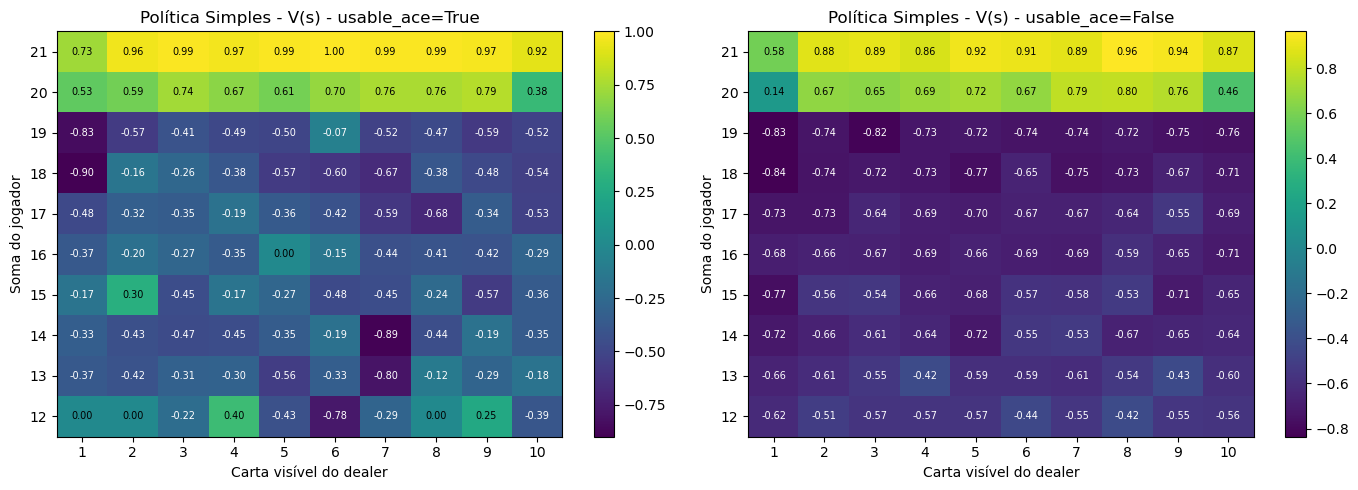

In [14]:
# 3. Visualizar
plot_value_heatmap(V_simple, title_prefix="Política Simples - ", 
                  state_values=True, fmt='.2f')


 TESTE 2: Política Avançada (Heurística)
Episódios: 2000/20000
Episódios: 4000/20000
Episódios: 6000/20000
Episódios: 8000/20000
Episódios: 10000/20000
Episódios: 12000/20000
Episódios: 14000/20000
Episódios: 16000/20000
Episódios: 18000/20000
Episódios: 20000/20000
✓ Estados estimados: 280
✓ Valor médio: 0.0555


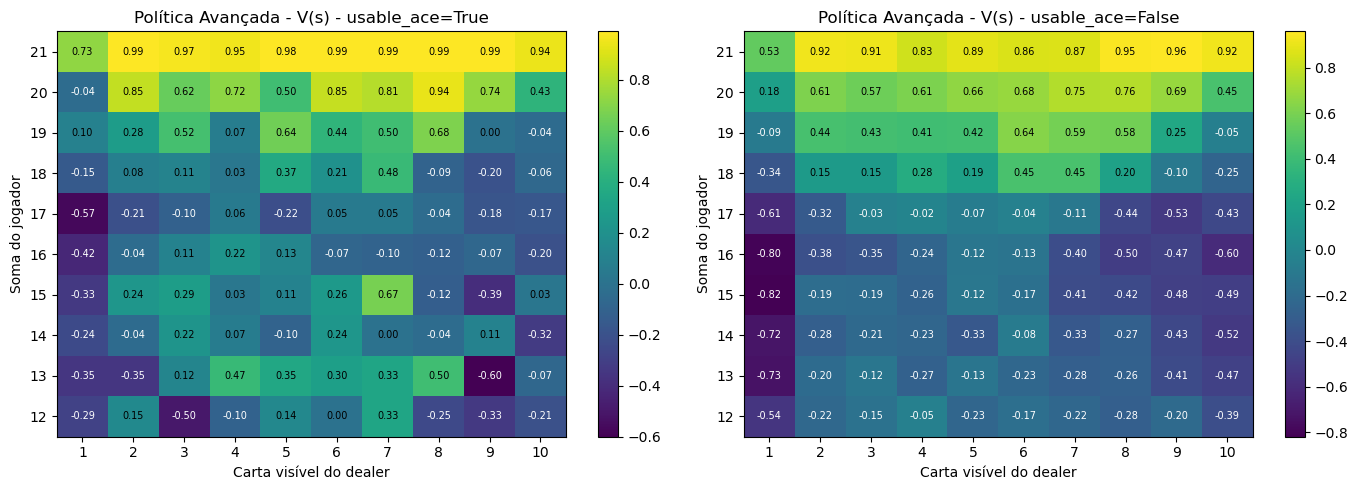

In [16]:
# 4. Rodar predição com política avançada
print("\n" + "="*70)
print(" TESTE 2: Política Avançada (Heurística)")
print("="*70)

V_advanced = first_visit_MC_prediction(
    env, policy_blackjack_advanced, episodes=20000, gamma=1.0, verbose=True
)

print(f"✓ Estados estimados: {len(V_advanced)}")
print(f"✓ Valor médio: {np.mean(list(V_advanced.values())):.4f}")

plot_value_heatmap(V_advanced, title_prefix="Política Avançada - ",
                  state_values=True, fmt='.2f')

In [17]:
# 5. Avaliar performance
print("\n" + "="*70)
print(" TESTE 3: Avaliação de Performance")
print("="*70)

print("\n[1/2] Avaliando Política Simples...")
stats_simple = avaliar_politica_prediction(env, policy_blackjack, 
                                           n_jogos=10000, verbose=True)

print("\n[2/2] Avaliando Política Avançada...")
stats_advanced = avaliar_politica_prediction(env, policy_blackjack_advanced,
                                             n_jogos=10000, verbose=True)


 TESTE 3: Avaliação de Performance

[1/2] Avaliando Política Simples...
  Progresso:   1000/10000 jogos | Win rate atual: 27.00%
  Progresso:   2000/10000 jogos | Win rate atual: 29.65%
  Progresso:   3000/10000 jogos | Win rate atual: 29.50%
  Progresso:   4000/10000 jogos | Win rate atual: 29.83%
  Progresso:   5000/10000 jogos | Win rate atual: 29.64%
  Progresso:   6000/10000 jogos | Win rate atual: 29.43%
  Progresso:   7000/10000 jogos | Win rate atual: 29.47%
  Progresso:   8000/10000 jogos | Win rate atual: 29.70%
  Progresso:   9000/10000 jogos | Win rate atual: 29.64%
  Progresso:  10000/10000 jogos | Win rate atual: 29.73%

 RESULTADOS DA AVALIAÇÃO
Total de jogos:      10,000
------------------------------------------------------------
Vitórias:             2,973  ( 29.73%)
Derrotas:             6,470  ( 64.70%)
Empates:                557  (  5.57%)
------------------------------------------------------------
Recompensa média:   -0.3497

📊 INTERPRETAÇÃO:
   ❌ FRACO. Políti


 TESTE 4: Comparação Entre Políticas

 COMPARAÇÃO DE POLÍTICAS

[Testando] Simples (≥20)...
  ✓ Win Rate: 29.71%
  ✓ Avg Reward: -0.3514

[Testando] Avançada (Heurística)...
  ✓ Win Rate: 43.23%
  ✓ Avg Reward: -0.0444


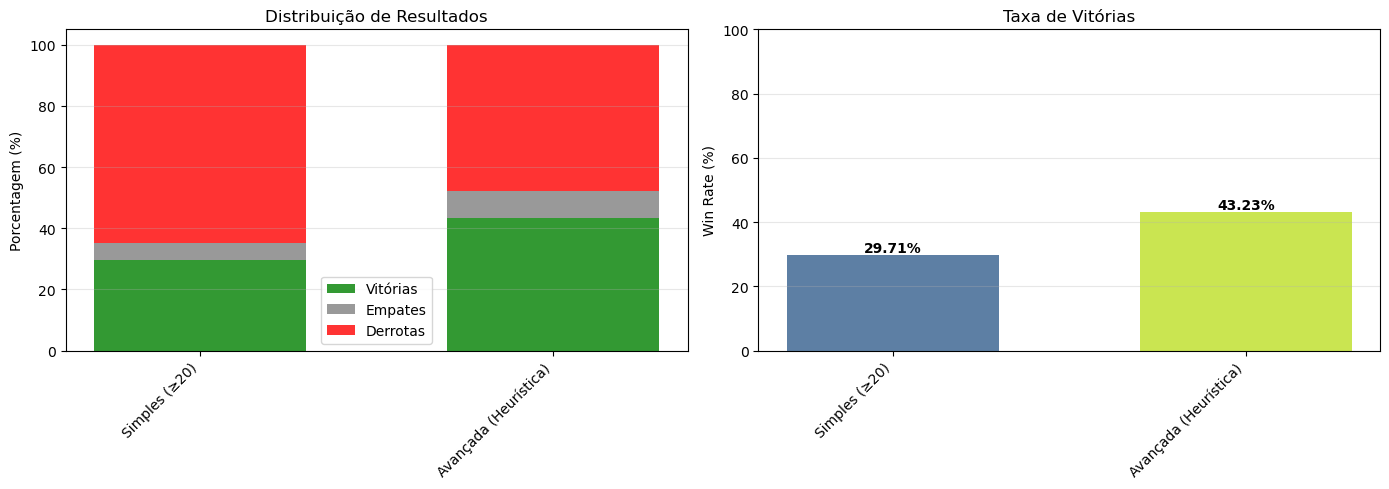

In [18]:
 # 6. Comparar políticas
print("\n" + "="*70)
print(" TESTE 4: Comparação Entre Políticas")
print("="*70)

policies = {
    'Simples (≥20)': policy_blackjack,
    'Avançada (Heurística)': policy_blackjack_advanced
}
comparacao = comparar_politicas_prediction(env, policies, n_jogos=10000)


 TESTE 5: Análise de Convergência
Calculando convergência para 20000 episódios...
  2000/20000 episódios completos
  4000/20000 episódios completos
  6000/20000 episódios completos
  8000/20000 episódios completos
  10000/20000 episódios completos
  12000/20000 episódios completos
  14000/20000 episódios completos
  16000/20000 episódios completos
  18000/20000 episódios completos
  20000/20000 episódios completos


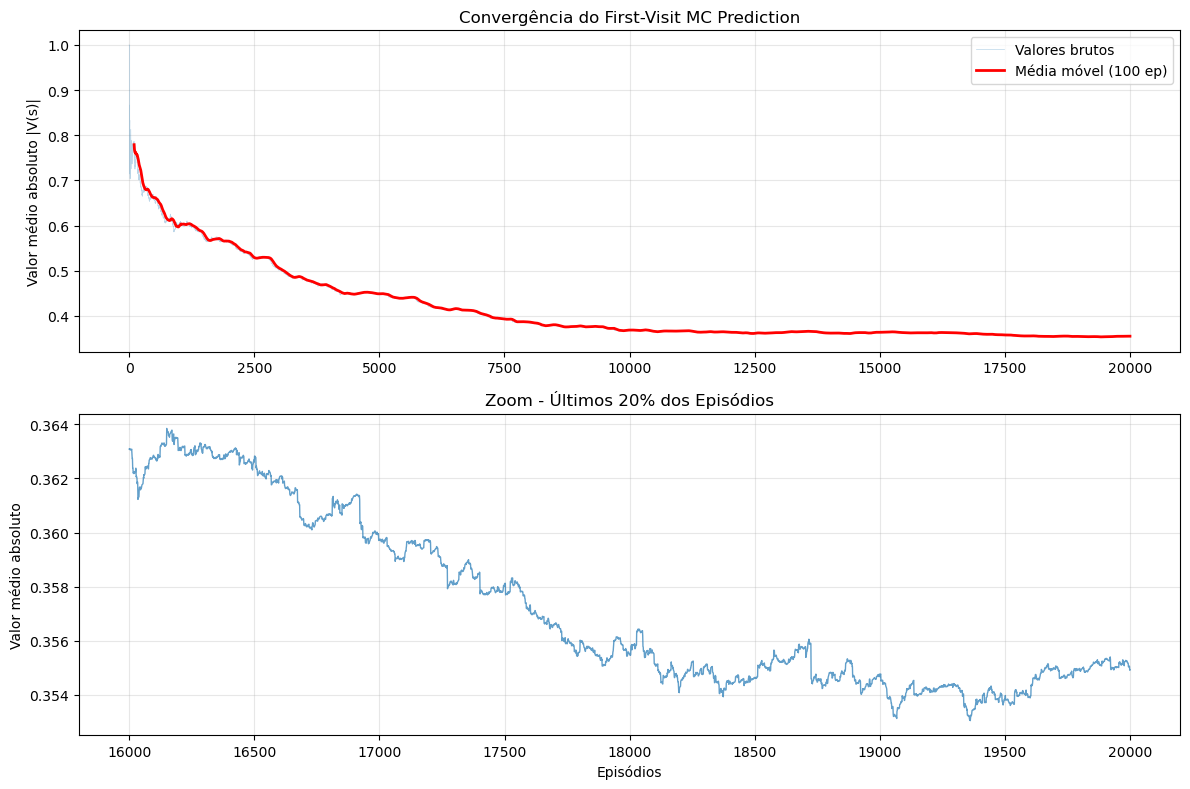

CPU times: total: 9.59 s
Wall time: 9.53 s


In [19]:
%%time
# 7. Convergência
print("\n" + "="*70)
print(" TESTE 5: Análise de Convergência")
print("="*70)

V_conv = plot_convergence(env, policy_blackjack_advanced, 
                          episodes=20000, gamma=1.0, window=100)

In [20]:
# 8. Tabelas
print("\n" + "="*70)
print(" VALORES ESTIMADOS V(s)")
print("="*70)

df_true = value_dict_to_dataframe(V_advanced, has_ace=True)
df_false = value_dict_to_dataframe(V_advanced, has_ace=False)

print('\nV(s) - Usable Ace = True')
print(df_true.to_string())

print('\n\nV(s) - Usable Ace = False')
print(df_false.to_string())

print("\n" + "="*70)
print(" ANÁLISE COMPLETA FINALIZADA!")
print("="*70)


 VALORES ESTIMADOS V(s)

V(s) - Usable Ace = True
dealer_card        1         2         3         4         5         6         7         8         9         10
player_sum                                                                                                     
12          -0.285714  0.153846 -0.500000 -0.100000  0.142857  0.000000  0.333333 -0.250000 -0.333333 -0.206897
13          -0.350000 -0.350000  0.125000  0.470588  0.352941  0.300000  0.333333  0.500000 -0.600000 -0.069767
14          -0.240000 -0.043478  0.222222  0.066667 -0.095238  0.238095  0.000000 -0.040000  0.105263 -0.322917
15          -0.333333  0.235294  0.285714  0.033333  0.105263  0.259259  0.666667 -0.125000 -0.392857  0.025974
16          -0.423077 -0.038462  0.107143  0.222222  0.130435 -0.074074 -0.095238 -0.115385 -0.066667 -0.203540
17          -0.565217 -0.214286 -0.103448  0.055556 -0.218750  0.047619  0.052632 -0.037037 -0.181818 -0.171171
18          -0.148148  0.083333  0.111111  0.031250  